In [1]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
from typing import List, Optional, Tuple, Union, Dict
import math
from simulator import MdUpdate, Order, OwnTrade, Sim, update_best_positions
import bisect

In [2]:
"""
    Load medium (2 hour) data, it is enough to test liquidating strategies
"""

T = pd.Timedelta(2, 'h').delta
PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'

md_medium = load_md_from_file(path=PATH_TO_FILE, T = T)
# md_large = load_md_from_file(path=PATH_TO_FILE)

md_run = md_medium

In [3]:
"""
    Populate future price lookup array 
"""

prices_lookup = []

for data in md_run:
    if data.orderbook:
        ts = data.exchange_ts
        price = (data.orderbook.asks[0][0] + data.orderbook.bids[0][0]) / 2
        prices_lookup.append((ts, price))
        
print(len(prices_lookup))
print(prices_lookup[:20])

206524
[(1655942402249000000, 19977.45), (1655942402655000000, 19977.45), (1655942403346000000, 19977.45), (1655942404080000000, 19977.45), (1655942404452000000, 19977.45), (1655942404488000000, 19977.45), (1655942404751000000, 19977.45), (1655942405044000000, 19977.45), (1655942405249000000, 19977.45), (1655942405308000000, 19977.95), (1655942405982000000, 19977.95), (1655942406208000000, 19977.95), (1655942407114000000, 19977.95), (1655942407796000000, 19977.95), (1655942407823000000, 19977.95), (1655942408072000000, 19977.95), (1655942408217000000, 19977.95), (1655942408898000000, 19977.95), (1655942409190000000, 19977.95), (1655942409199000000, 19977.95)]


In [4]:
"""
    Get future price and boolean of end of data
"""

def get_future_price(cur_ts, dt = 1):
    ts = cur_ts + pd.Timedelta(dt, 's').delta
    ind = bisect.bisect_left(prices_lookup, (ts, -1))
    
    if ind < len(prices_lookup):
        return prices_lookup[ind][1], False
    else:
        return prices_lookup[-1][1], True

In [5]:
"""
    Stoikov, Mid Price, Future Predict - three modes of a model
"""

class AroundMidOrFuture:
    def __init__(self, delay, func_kappa, theta_2, mode = 'future_predict', 
                 closing_str = 'close', limit_t = 60 * 60, closing_size = 0.1) -> None:
        """
            closing_strategy
            limit_t - start liquidating limit_t seconds before end of data
            closing_size - size of the trades made when liquidating
        """
        
        self.q = 0
        
        # we maintain a moving variance of an asset price
        self.var = 0
        self.var_period = 100 * 1000
        self.coin_prices = []
        
        # period of order making
        self.delay = delay
        # variable for -  2 / g * ln(1 + g / k)
        self.func_kappa = func_kappa
        # variable for - g * (T - t)
        self.theta_2 = theta_2
        
        # for statistics and plots
        self.mid_prices = []
        self.my_asks = []
        self.my_bids = []
        self.res_prices = []
        self.time = []
        self.spreads = []
        
        # future look up
        self.mode = mode
        self.closing_str = closing_str
        self.limit_t = limit_t # given in seconds
        self.INF = 10 ** 9
        self.trade_size = 0.01
        self.trade_size_closing = closing_size

    
    def sigma_sq(self):
        if len(self.coin_prices) >= self.var_period:
            # return estimated variance: sum[(x(i+1) - x(i)) ^ 2] / var_period
            return self.var / self.var_period
        else:
            # weighted average with 0.1 variance
            remain = self.var_period - len(self.coin_prices)
            return (self.var + 0.1 * remain) / self.var_period


    def ask_bid(self, s, ts, best_bid, best_ask):
        var = self.sigma_sq()
        reservation_price = s - self.q * var * self.theta_2
        spread = var * self.theta_2 + self.func_kappa

        if self.mode == 'mid_price':
            reservation_price = s
        if self.mode == 'future_predict':
            reservation_price, _ = get_future_price(ts)
            _, end_of_data = get_future_price(ts, self.limit_t)
            
            if self.closing_str[:5] == 'close' and end_of_data:
                if self.q > 0.00001:
                    return best_ask, -self.INF, min(self.trade_size_closing, self.q)
                elif self.q < -0.00001:
                    return self.INF, best_bid, min(self.trade_size_closing, -self.q)
                else:
                    return self.INF, -self.INF, 0

        return reservation_price + spread / 2, reservation_price - spread / 2, self.trade_size
    

    def run(self, sim: Sim) -> \
            Tuple[List[OwnTrade], List[MdUpdate], List[Union[OwnTrade, MdUpdate]], List[Order]]:
        # market data list
        md_list: List[MdUpdate] = []
        # executed trades list
        trades_list: List[OwnTrade] = []
        # all updates list
        updates_list = []
        # current best positions
        best_bid = -np.inf
        best_ask = np.inf
        mid_price = 0

        # last order timestamp
        prev_time = -np.inf
        # orders that have not been executed/canceled yet
        self.ongoing_orders: Dict[int, Order] = {}
        all_orders = []

        while True:
            # get update from simulator
            receive_ts, updates = sim.tick()
            if updates is None:
                break
            # save updates
            updates_list += updates
            for update in updates:
                # update best position
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    mid_price = (best_bid + best_ask) / 2
                    md_list.append(update)
                    
                    self.coin_prices.append(mid_price)
                    if len(self.coin_prices) >= 2:
                        self.var += (self.coin_prices[-1] - self.coin_prices[-2]) ** 2
                    if len(self.coin_prices) >= self.var_period + 1:
                        self.var -= (self.coin_prices[-self.var_period] - self.coin_prices[-self.var_period - 1]) ** 2
                elif isinstance(update, OwnTrade):
                    if update.side == 'BID':
                        self.q += update.size
                    if update.side == 'ASK':
                        self.q -= update.size
                    trades_list.append(update)
                    # delete executed trades from the dict
                    if update.order_id in self.ongoing_orders.keys():
                        self.ongoing_orders.pop(update.order_id)
                else:
                    assert False, 'invalid type of update!'

            if receive_ts - prev_time >= self.delay:
                prev_time = receive_ts

                # cancel current limit orders
                to_cancel = []
                for ID, order in self.ongoing_orders.items():
                    sim.cancel_order(receive_ts, ID)
                    to_cancel.append(ID)
                for ID in to_cancel:
                    self.ongoing_orders.pop(ID)

                # place new orders on current reservation price and spread
                ask, bid, tr_size = self.ask_bid(mid_price, receive_ts, best_bid, best_ask)
                
                if ask != self.INF:
                    ask_order = sim.place_order(receive_ts, tr_size, 'ASK', ask)
                    self.ongoing_orders[ask_order.order_id] = ask_order
                    self.my_asks.append((ask_order.order_id, ask))
                if bid != -self.INF:
                    bid_order = sim.place_order(receive_ts, tr_size, 'BID', bid)
                    self.ongoing_orders[bid_order.order_id] = bid_order
                    self.my_bids.append((bid_order.order_id, bid))
                
                # record statistics to make plots about the limit orders
                self.time.append(receive_ts)
                self.mid_prices.append(mid_price)
                self.res_prices.append(((ask + bid) / 2, self.q))
                self.spreads.append(ask - bid)

                all_orders += [bid_order, ask_order]

        return trades_list, md_list, updates_list, all_orders

In [6]:
"""
    Given pnl at each time step, we compute sharpe ratio
"""

def get_sharpe(worth_list):
    pnl = worth_list[-1] - worth_list[0]
    aver_dpnl = pnl / (len(worth_list) - 1)
    var_dpnl = 0

    for i in range(len(worth_list) - 1):
        dpnl = worth_list[i + 1] - worth_list[i]
        var_dpnl += (dpnl - aver_dpnl) ** 2

    # no trades and pnl zero everywhere
    if var_dpnl < 0.000001:
        return -1, 0, 0
    
    sigma_dpnl = math.sqrt(var_dpnl / (len(worth_list) - 1))
    sharpe = pnl / sigma_dpnl
    
    return sharpe, pnl, sigma_dpnl

In [7]:
"""
    All our strategies liquidate inventory by putting limit orders at best levels on one side only
    
    Successful:
    1) ('close', 5 * 60, 0.01) - we start closing our position 5 minutes before end of trade
    We liquidate 0.01 btc per order (same as default order size)
    
    2) ('close', 1 * 60, 0.1) - we start closing our position 1 minute before end of trade
    We liquidate 0.1 btc per order (10 times of default size)
    
    Not successful:
    3) ('close', 1 * 60, 0.01) - we start closing 1 minute before end of trade 
    We liquidate 0.01 btc per order
    Fail to liquidate all inventory with such small orders and little time
"""

pnl_xs, pnl_ys = [], []
inv_xs, inv_ys = [], []
spread_xs, spread_ys = [], []
closing_strategies = [('close', 5 * 60, 0.01), ('close', 1 * 60, 0.1), ('close', 1 * 60, 0.01)]

for cl_str in closing_strategies:
    latency = pd.Timedelta(10, 'ms').delta
    md_latency = pd.Timedelta(10, 'ms').delta
    sim = Sim(md_run, latency, md_latency)

    delay = pd.Timedelta(0.1, 's').delta
    strategy = AroundMidOrFuture(delay, 8, 70, 'future_predict', cl_str[0], cl_str[1], cl_str[2])

    trades_list, md_list, updates_list, all_orders = strategy.run(sim)
    receive_ts, worth_list, btc_pos_list, mid_price_list = get_pnl(updates_list)
    
    # Print statistics 
    sharpe, pnl, volatility = get_sharpe(worth_list)
    
    print('\nmodel:', cl_str)
    print('Final Position:', strategy.q)
    print('Final PNL:', pnl)
    print('Volatility of pnl:', volatility)
    print('Sharpe ratio:', sharpe)

    print('Total limit orders made:', 2 * len(strategy.mid_prices))
    print('Total filled orders:', len(trades_list))
    print('Total hanging orders:', len(strategy.ongoing_orders))
    
    dt = pd.to_datetime(receive_ts)
    pnl_xs.append(dt)
    pnl_ys.append(worth_list)
    
    inv_xs.append(dt)
    inv_ys.append(btc_pos_list)
    
    spread_xs.append(pd.to_datetime(strategy.time))
    spread_ys.append(strategy.spreads)


model: ('close', 300, 0.01)
Final Position: 1.3530843112619095e-16
Final PNL: 216.31628201528483
Volatility of pnl: 0.7777637284307815
Sharpe ratio: 278.1259579329127
Total limit orders made: 126508
Total filled orders: 4034
Total hanging orders: 0

model: ('close', 60, 0.1)
Final Position: 0.0
Final PNL: 284.10622607050016
Volatility of pnl: 0.794884646914397
Sharpe ratio: 357.4181828437004
Total limit orders made: 126508
Total filled orders: 3729
Total hanging orders: 0

model: ('close', 60, 0.01)
Final Position: 1.3800000000000012
Final PNL: 248.53922607176355
Volatility of pnl: 0.7967027507201764
Sharpe ratio: 311.95979409773275
Total limit orders made: 126514
Total filled orders: 3972
Total hanging orders: 0


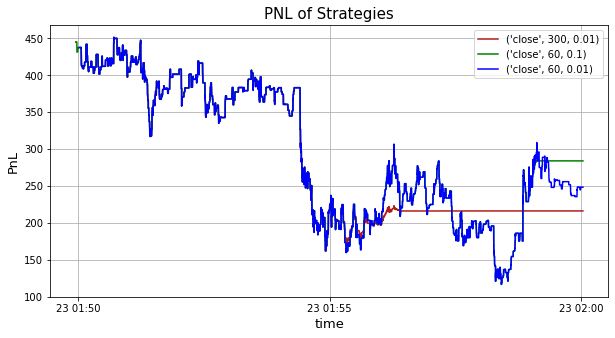

In [11]:
"""
    Plot PNL
"""

colors = [(0.7, 0.1, 0.1), 'g', 'b']

plt.figure(figsize=(10, 5))
for i in range(3):
    # We crop data, because before last 5 minutes they have same plot
    x, y = pnl_xs[i][-50000:], pnl_ys[i][-50000:]
    plt.plot(x, y, '-', color = colors[i], label = closing_strategies[i])
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("PNL of Strategies", fontsize=15)
plt.grid()
plt.legend()
plt.show()

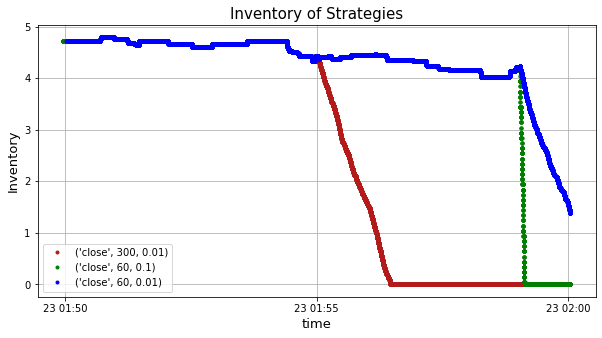

In [12]:
"""
    Plot Inventory
"""

plt.figure(figsize=(10, 5))
for i in range(3):
    # We crop data, because before last 5 minutes they have same plot
    x, y = inv_xs[i][-50000:], inv_ys[i][-50000:]
    plt.plot(x, y, '.', color = colors[i], label = closing_strategies[i])
plt.xlabel("time", fontsize=13)
plt.ylabel("Inventory", fontsize=13)
plt.title("Inventory of Strategies", fontsize=15)
plt.grid()
plt.legend()
plt.show()

#### Заключение 

Я сравнил стратегии закрытия которые ставят свои ордера на бест прайсы на одну сторону, а на другую ничего не ставят. Это совпадает с выводами из статьи которую мы читали, что с одной стороны книги нужно уберать ордеры, а по другую на бест уровень ставить ордеры. 

Я игрался с временем за сколько до конца закрывал позицию, плюс с размером ордера. 

1) Мы поняли что за 5 минут можно не спеша с ордерами 0.01 закрыть позицию в 4btc <br>
2) Или же спеша за 1 минуту с ордерами 0.1 закрыть позицию в 4btc <br>
3) Но если мы будет за 1 минуту, пытаться закрыть с маленькими ордерами нашу позицию, то мы не успеем.<br>

Можно заметить что графики pnl испытали не сильный дроп из за закрытия всей позиций. Также, видно что наш инвентори понижается с некоторой линейной скоростью в зависимости от размера ордера. Видно например что у красного и синего графика, которые начали закрывать позицию в разное время одинковый слоуп в течений всего времени ликвидаций. Это скорее всего, потому что нас всегда испольняют маркет ордера на лучших уровнях, и мы ставим лимитные ордера каждые 0.1 секунд. Упс! Это неправильно, наверное после каждого испольнения нам надо обратно становиться в стакан.

Я не стал включать графики полной стратегий за все время, потому что здесь мы сфокусированы на алгоритме закрытия. И плюс график совпадал бы с прошедшей домашкой.

Наша стратегия в плюсе по pnl, так как она смотрит цены в будущем.

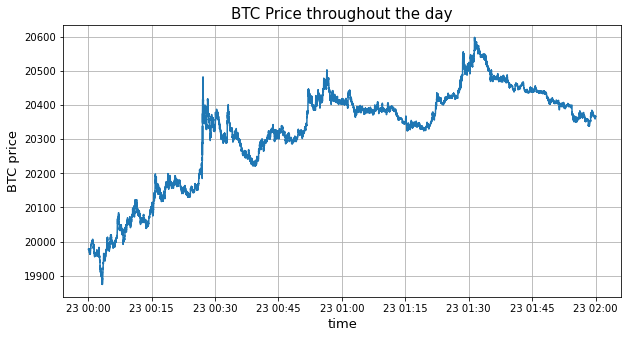

In [10]:
"""
    BTC price plot for reference
"""

plt.figure(figsize=(10, 5))
plt.plot(dt, mid_price_list, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("BTC price", fontsize=13)
plt.title("BTC Price throughout the day", fontsize=15)
plt.grid()
plt.show()